# **Census Analysis**

In [287]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.cluster import AgglomerativeClustering
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import warnings
import json


In [288]:
DATA_PATH = "../data/1832_v4_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
df["chef_origine_class"] = df["chef_origine_class"].astype("category")
df["chef_vocation_class"] = df["chef_vocation_class"].astype("category")
print(df.shape[0])
df.head()

3803


,nom_rue,no_maison,chef_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,pensionnaires,enfants,page,division,chef_vocation_class,chef_origine_class,division_class,division_name
0,marterey,1,1764.0,tolochenaz,1786.0,charon,4.0,0.0,1,1,NaN,morges,culture,marterey
1,marterey,2,NaN,rolle,1821.0,marechal-ferrant,2.0,3.0,1,1,artisanat,rolle,culture,marterey
2,marterey,3,1785.0,pailly,NaN,lingere,2.0,1.0,1,1,service,moudon,culture,marterey
3,marterey,3,NaN,gingins,NaN,rentier,3.0,1.0,1,1,rente,NaN,culture,marterey
4,marterey,3,NaN,gingins,NaN,rentier,3.0,1.0,1,1,rente,NaN,culture,marterey


In [299]:
division_id_to_name = {1: 'Marterey',
 2: 'Cheneau de Bourg',
 3: 'Bourg',
 4: 'Place St-Francois',
 5: 'Montée St-Francois',
 6: 'Rue du Pont',
 7: 'Montée de St Laurent',
 8: 'Grand St-Jean',
 9: 'St-Laurent',
 10: 'Ale',
 11: 'Palud',
 12: 'Cité Dessous',
 13: 'cité Derriere',
 14: 'Barre',
 15: 'Ouchy',
 16: 'Chailly',
 17: 'La Sallaz',
 18: 'Grange-Neuve'}

## **K-Means**

In [300]:
def get_df_cluster(df, features, n_bootstrap, permute):
    new_df = df.copy()

    # Bootstrap
    new_df = new_df.sample(n=n_bootstrap, replace=True)

    # Permute features
    if permute:
        for feature in features:
            new_df[feature] = np.random.permutation(new_df[feature])

    # Select only the columns we want to cluster
    df_cluster = new_df[features + ["division"]]

    # Drop nans
    df_cluster = df_cluster.dropna()

    # Get the number of clusters
    n_clusters = df_cluster["division"].nunique()

    # Get the dummies
    df_cluster_dummies = pd.get_dummies(df_cluster)

    # Remove the division column as we want to predict it
    df_cluster_dummies = df_cluster_dummies.drop(columns=["division"])

    # Standardize the data
    df_cluster_dummies = stats.zscore(df_cluster_dummies)
    df_cluster_dummies = np.nan_to_num(df_cluster_dummies)
    
    # Get the clusters
    k_means = KMeans(n_clusters=n_clusters, n_init='auto')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        k_means.fit(df_cluster_dummies)
    cluster_labels = k_means.labels_
    #agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    #agglomerative_clustering.fit(df_cluster_dummies)
    #cluster_labels = agglomerative_clustering.labels_
    df_cluster["cluster"] = cluster_labels

    return df_cluster

def get_cluster_division_assignment(df_cluster):
    # Get the max count in each division
    df_cluster_class = df_cluster.groupby(['division', 'cluster']).size().reset_index(name="count")
    df_cluster_class_max = df_cluster_class.groupby(['division']).agg({'count': 'max'}).rename(columns={'count': 'max_count'}).reset_index()

    # Start with an empty dictionary to store cluster assignments
    division_cluster_assignment = {}
    assigned_clusters = set()
    all_clusters = set(df_cluster_class['cluster'])

    # Sort divisions by their maximum cluster count
    df_cluster_class_max.sort_values('max_count', ascending=False, inplace=True)

    # Go through divisions one by one
    for division in df_cluster_class_max['division']:
        division_rows = df_cluster_class[df_cluster_class['division'] == division].copy()
        division_rows.sort_values('count', ascending=False, inplace=True)

        # Go through clusters within this division, starting with the one with highest count
        for idx, row in division_rows.iterrows():
            if row['cluster'] not in assigned_clusters:
                division_cluster_assignment[division] = row['cluster']
                assigned_clusters.add(row['cluster'])
                break
        # If all clusters are already assigned, assign this division to the cluster with lowest count that is not yet assigned
        else:
            for cluster in all_clusters:
                if cluster not in assigned_clusters:
                    division_cluster_assignment[division] = cluster
                    assigned_clusters.add(cluster)
                    break

    cluster_division_assignment = {v: k for k, v in division_cluster_assignment.items()}
    return cluster_division_assignment

def get_f1_score(df_cluster, features, permute):
    cluster_division_assignment = get_cluster_division_assignment(df_cluster)
    df_cluster['assigned_division'] = df_cluster['cluster'].map(cluster_division_assignment)

    return f1_score(df_cluster["division"], df_cluster["assigned_division"], average="weighted")

In [301]:
def generate_f1_scores(df, features, n_runs, n_bootstrap, permute):
    f1_scores = []
    for _ in tqdm(range(n_runs)):
        df_cluster = get_df_cluster(df, features, n_bootstrap, permute)
        f1_score = get_f1_score(df_cluster, features, permute)
        f1_scores.append(f1_score)

    return f1_scores

def get_f1_stats(non_premuted_f1_scores, premuted_f1_scores, alpha=0.05):
    # Get CIs
    non_permuted_ci_lower, non_permuted_ci_upper = np.percentile(non_premuted_f1_scores, [(alpha/2)*100, (1-alpha/2)*100])
    permuted_ci_lower, permuted_ci_upper = np.percentile(premuted_f1_scores, [(alpha/2)*100, (1-alpha/2)*100])

    # Calculate p-value
    p_value = np.sum(np.array(premuted_f1_scores) >= np.array(non_premuted_f1_scores)) / len(premuted_f1_scores)

    # Compute paired t-test
    t_stat, t_p_value = stats.ttest_rel(non_premuted_f1_scores, premuted_f1_scores)

    return non_permuted_ci_lower, non_permuted_ci_upper, permuted_ci_lower, permuted_ci_upper, p_value, t_stat, t_p_value

def show_stats(
    non_permuted_f1_scores,
    permuted_f1_scores,
    non_permuted_ci_lower, 
    non_permuted_ci_upper, 
    permuted_ci_lower, 
    permuted_ci_upper, 
    p_value, 
    t_stat, 
    t_p_value,
    features
):
    # Plot histograms with same bin edges
    bin_edges = np.linspace(min(min(non_permuted_f1_scores), min(permuted_f1_scores)),
                            max(max(non_permuted_f1_scores), max(permuted_f1_scores)),
                            21)
    plt.hist(non_permuted_f1_scores, bins=bin_edges, alpha=0.5, label='Non-permuted')
    plt.hist(permuted_f1_scores, bins=bin_edges, alpha=0.5, label='Permuted')

    # Plot vertical lines for confidence intervals
    plt.axvline(non_permuted_ci_lower, color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(non_permuted_ci_upper, color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(permuted_ci_lower, color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(permuted_ci_upper, color='orange', linestyle='dashed', linewidth=1)

    plt.legend(loc='upper right')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of F1 scores on {", ".join(features)}\np-value={p_value:.3f}, t-stat={t_stat:.3f}, t-p-value={t_p_value:.3f}')
    plt.show()

In [302]:
def run_and_show_stats(df, features, n_bootstrap, n_runs):
    non_permuted_f1_scores = generate_f1_scores(df, features, n_runs, n_bootstrap, permute=False)
    permuted_f1_scores = generate_f1_scores(df, features, n_runs, n_bootstrap, permute=True)

    non_permuted_ci_lower, non_permuted_ci_upper, \
    permuted_ci_lower, permuted_ci_upper, \
    p_value, t_stat, t_p_value = get_f1_stats(non_permuted_f1_scores, permuted_f1_scores, alpha=0.05)

    show_stats(
        non_permuted_f1_scores,
        permuted_f1_scores,
        non_permuted_ci_lower,
        non_permuted_ci_upper,
        permuted_ci_lower,
        permuted_ci_upper,
        p_value,
        t_stat,
        t_p_value,
        features=features
    )

## **Year of Arrival Analysis**

In [269]:
N_RUNS = 1000
N_BOOTSTRAP = 10000
FEATURES = ['chef_annee_arrivee']

run_and_show_stats(df, features=FEATURES, n_bootstrap=N_BOOTSTRAP, n_runs=N_RUNS)

 43%|████▎     | 429/1000 [00:12<00:16, 34.75it/s]


KeyboardInterrupt: 

In [303]:
N_TRIES = 100
N_BOOTSTRAP = 100000
FEATURES = ['chef_annee_arrivee']# ['chef_vocation_class', 'chef_origine_class', 'chef_annee_naissance', 'chef_annee_arrivee']

best_f1_score_val = 0
best_df_cluster = None
for _ in range(N_TRIES):
    # Fit the data
    df_cluster = get_df_cluster(df, features=FEATURES, n_bootstrap=N_BOOTSTRAP, permute=False)
    cluster_division_assignment = get_cluster_division_assignment(df_cluster)
    df_cluster['assigned_division'] = df_cluster['cluster'].map(cluster_division_assignment)

    # Evaluate the model
    f1_score_val = f1_score(df_cluster["division"], df_cluster["assigned_division"], average="weighted")
    if f1_score_val > best_f1_score_val:
        print(f"New best F1 score: {f1_score_val}")
        best_f1_score_val = f1_score_val
        best_df_cluster = df_cluster

best_df_cluster.head()

New best F1 score: 0.16997438577968274
New best F1 score: 0.17060817404936604
New best F1 score: 0.17387573054731256
New best F1 score: 0.18078311612384682
New best F1 score: 0.18700898000797023
New best F1 score: 0.18795584300844828
New best F1 score: 0.19656064722460723


,chef_annee_arrivee,division,cluster,assigned_division
1854,1824.0,8,8,9
3609,1830.0,15,3,1
3475,1831.0,15,3,1
3580,1812.0,15,7,16
2150,1819.0,9,9,5


In [304]:
# Get assigned division sizes
df_cluster_fit = best_df_cluster.copy()
df_cluster_fit = df_cluster_fit.merge(df_cluster_fit.groupby('assigned_division').size().reset_index(name='assigned_division_size'), on='assigned_division')

# Filter out wrong predictions and get filtered assigned division sizes
df_cluster_fit = df_cluster_fit[df_cluster_fit['division'] == df_cluster_fit['assigned_division']]
df_cluster_fit = df_cluster_fit.merge(df_cluster_fit.groupby('assigned_division').size().reset_index(name='count'), on='assigned_division')

# Get ratio of filtered assigned division sizes to assigned division sizes
df_cluster_fit['ratio'] = df_cluster_fit['count'] / df_cluster_fit['assigned_division_size']
df_cluster_fit = df_cluster_fit[['division', 'ratio', 'count']].drop_duplicates().sort_values(by='ratio', ascending=False)
df_cluster_fit = df_cluster_fit.sort_values(by='ratio', ascending=False)
df_cluster_fit.head(20)

,division,ratio,count
527,1,0.309379,1425
2976,15,0.293078,398
2231,10,0.251855,577
0,9,0.235268,527
3427,4,0.220273,113
2808,8,0.115702,168
1952,16,0.101592,134
2175,7,0.088889,56
2086,5,0.059852,89
3374,17,0.035884,53


In [305]:
# Map division id to name
best_df_cluster['division'] = best_df_cluster['division'].map(division_id_to_name)
best_df_cluster['assigned_division'] = best_df_cluster['assigned_division'].map(division_id_to_name)

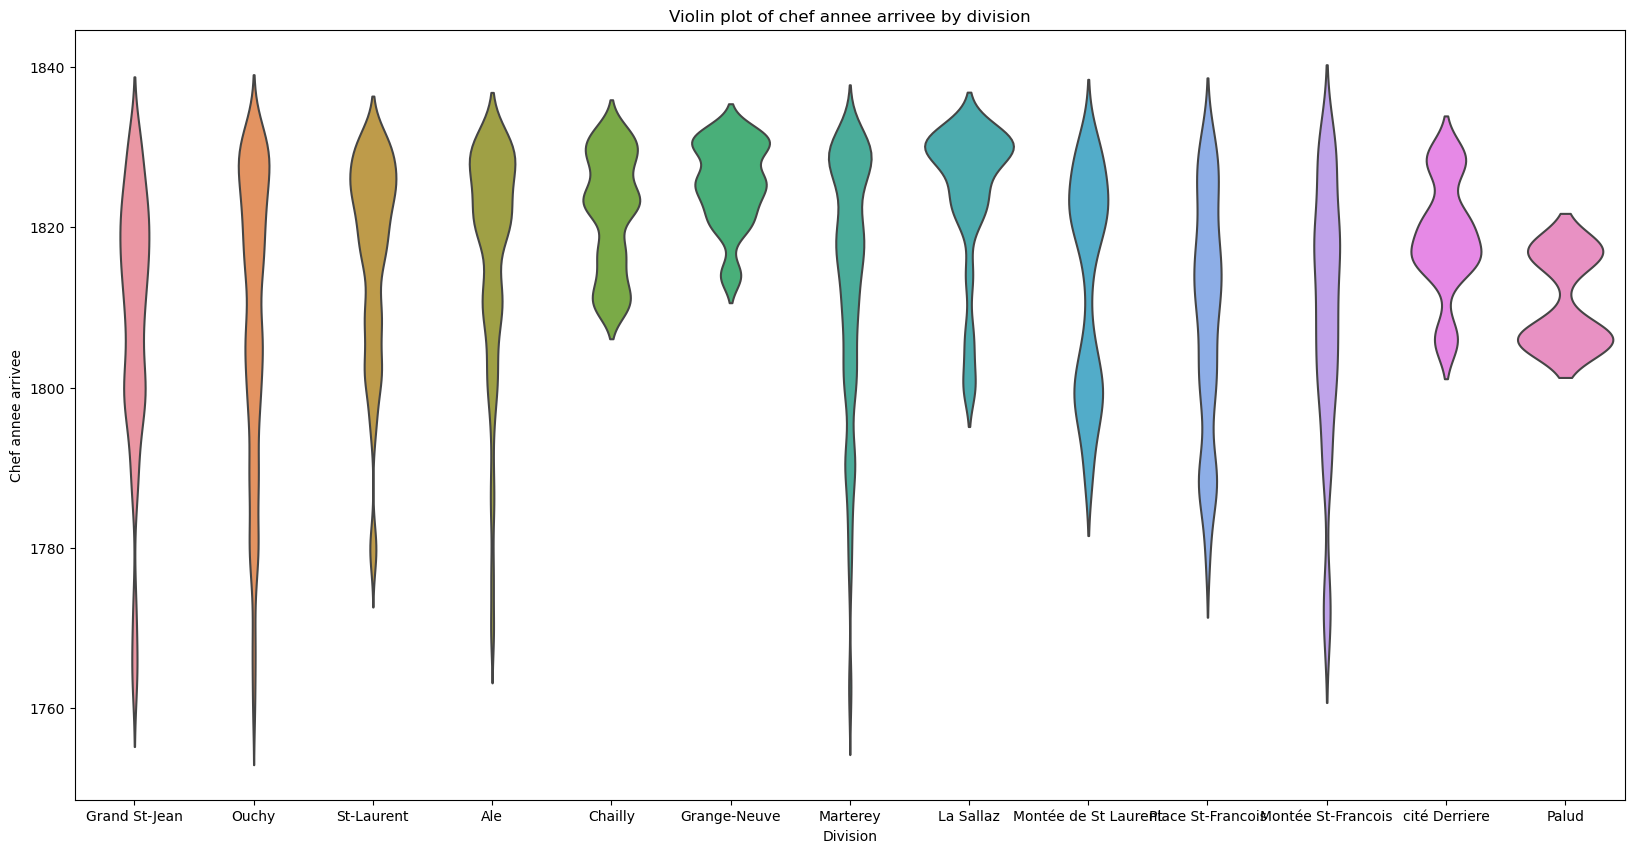

In [306]:
# Do the same but with violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(x='division', y='chef_annee_arrivee', data=best_df_cluster, inner=None)
plt.xlabel('Division')
plt.ylabel('Chef annee arrivee')
plt.title('Violin plot of chef annee arrivee by division')
plt.show()

In [307]:
data = []
for division in best_df_cluster['division'].unique(): # divisions are sorted by ratio in df_cluster_fit
    values = best_df_cluster[best_df_cluster['division'] == division]['chef_annee_arrivee'].values
    values = [int(value) for value in values]
    ratio = df_cluster_fit[df_cluster_fit['division'] == division]['ratio'].values
    ratio = float(ratio[0] if len(ratio) > 0 else 0)
    group_data = {
        'group': division,
        'values': values,
        'ratio': ratio
    }
    data.append(group_data)

# Save violin plot data
with open('../data/violin/violin_divisions.json', 'w') as f:
    json.dump(data, f, indent=4)

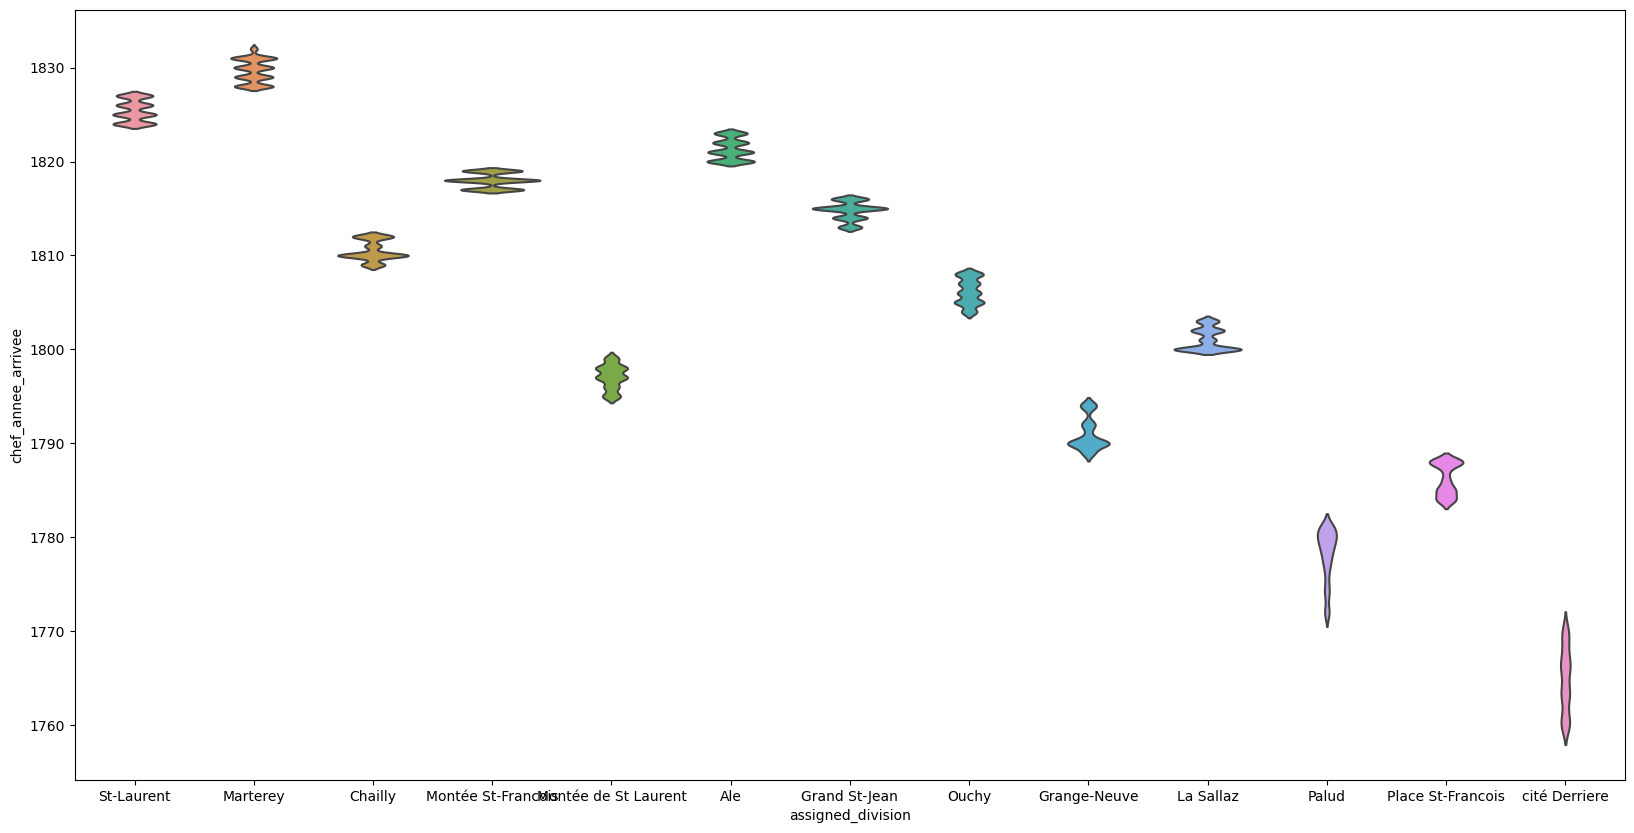

In [308]:
# Do the same but with violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(x='assigned_division', y='chef_annee_arrivee', data=best_df_cluster, inner=None)
plt.show()

In [310]:
data = []
for division in best_df_cluster['division'].unique(): # divisions are sorted by ratio in df_cluster_fit
    values = best_df_cluster[best_df_cluster['assigned_division'] == division]['chef_annee_arrivee'].values
    values = [int(value) for value in values]
    ratio = df_cluster_fit[df_cluster_fit['division'] == division]['ratio'].values
    ratio = float(ratio[0] if len(ratio) > 0 else 0)
    group_data = {
        'group': division,
        'values': values,
        'ratio': ratio
    }
    data.append(group_data)

# Save violin plot data
with open('../data/violin/violin_assigned_divisions.json', 'w') as f:
    json.dump(data, f, indent=4)

## **Generate Data**

In [53]:
STATS_FOLDER_DST = f'../data/stats/'
N_RUNS = 1000
N_BOOTSTRAP = 10000
MIN_X = 0.0
MAX_X = 0.35
NUM_BINS = 142

FEATURES = ['chef_vocation_class', 'chef_origine_class', 'chef_annee_naissance', 'chef_annee_arrivee']
names = {
    'chef_vocation_class': 'voc',
    'chef_origine_class': 'ori',
    'chef_annee_naissance': 'nai',
    'chef_annee_arrivee': 'arr'
}

# Save all histograms for all possible combinations of features
for i in range(1, len(FEATURES) + 1):
    for features in itertools.combinations(FEATURES, i):
        features = list(features)
        # Run simulations
        non_permuted_f1_scores = generate_f1_scores(df, features=features, n_runs=N_RUNS, n_bootstrap=N_BOOTSTRAP, permute=False)
        permuted_f1_scores = generate_f1_scores(df, features=features, n_runs=N_RUNS, n_bootstrap=N_BOOTSTRAP, permute=True)
        non_permuted_ci_lower, non_permuted_ci_upper, \
        permuted_ci_lower, permuted_ci_upper, \
        p_value, t_stat, t_p_value = get_f1_stats(non_permuted_f1_scores, permuted_f1_scores, alpha=0.05)

        # Compute bins for histograms
        bins = np.linspace(MIN_X, MAX_X, NUM_BINS)
        xs = bins[:-1] + round((bins[1] - bins[0]) / 2, 3)
        non_permuted_ys = np.histogram(non_permuted_f1_scores, bins=bins)[0]
        permuted_ys = np.histogram(permuted_f1_scores, bins=bins)[0]

        # Save in JSON file
        file_name = f'{STATS_FOLDER_DST}stats_{"_".join([names[f] for f in features])}.json'
        with open(file_name, 'w') as f:
            json.dump({
                'xs': xs.tolist(),
                'non_permuted_ys': non_permuted_ys.tolist(),
                'permuted_ys': permuted_ys.tolist(),
                'non_permuted_ci_lower': non_permuted_ci_lower,
                'non_permuted_ci_upper': non_permuted_ci_upper,
                'permuted_ci_lower': permuted_ci_lower,
                'permuted_ci_upper': permuted_ci_upper,
                'p_value': p_value,
                't_stat': t_stat,
                't_p_value': t_p_value,
                'features': features
            }, f, indent=4)

100%|██████████| 1000/1000 [00:31<00:00, 31.31it/s]
